In [129]:
import os
import pandas as pd
import networkx as nx

from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import textwrap

GAME_ID = 2022091112
PLAY_ID = 1674

In [130]:
def createFootballField(linenumbers=True,
                          endzones=True,
                          highlight_line=False,
                          highlight_line_number=50,
                          highlighted_name='Line of Scrimmage',
                          fifty_is_los=False,
                          figsize=(12, 6.33)):
    """
    Function that plots the football field for viewing plays.
    Allows for showing or hiding endzones.
    """

    # create figure
    rect = patches.Rectangle((0, 0), 120, 53.3, linewidth=0.1,
                             edgecolor='r', facecolor='gray', zorder=0)

    # create axis
    fig, ax = plt.subplots(1, figsize=figsize)
    ax.add_patch(rect)

    # plot field lines
    plt.plot([10, 10, 10, 20, 20, 30, 30, 40, 40, 50, 50, 60, 60, 70, 70, 80,
              80, 90, 90, 100, 100, 110, 110, 120, 0, 0, 120, 120],
             [0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3,
              53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 53.3, 0, 0, 53.3],
             color='white')
    
    # plot line of scrimmage at 50 yd line if fifty_is_los is True
    if fifty_is_los:
        plt.plot([60, 60], [0, 53.3], color='gold')
        plt.text(62, 50, '<- Player Yardline at Snap', color='gold')

    # Endzones
    if endzones:
        ez1 = patches.Rectangle((0, 0), 10, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='green',
                                alpha=0.2,
                                zorder=0)
        ez2 = patches.Rectangle((110, 0), 120, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='purple',
                                alpha=0.2,
                                zorder=0)
        ax.add_patch(ez1)
        ax.add_patch(ez2)

    # set axis limits
    plt.xlim(0, 120)
    plt.ylim(-5, 58.3)
    plt.axis('off')

    # plot line numbers
    if linenumbers:
        for x in range(20, 110, 10):
            numb = x
            if x > 50:
                numb = 120 - x
            plt.text(x, 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white')
            plt.text(x - 0.95, 53.3 - 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white', rotation=180)
            
    # checking the size of image to plot hash marks for each yd line
    if endzones:
        hash_range = range(11, 110)
    else:
        hash_range = range(1, 120)

    # plot hash marks
    for x in hash_range:
        ax.plot([x, x], [0.4, 0.7], color='white')
        ax.plot([x, x], [53.0, 52.5], color='white')
        ax.plot([x, x], [22.91, 23.57], color='white')
        ax.plot([x, x], [29.73, 30.39], color='white')

    # highlight line of scrimmage
    if highlight_line:
        hl = highlight_line_number + 10
        plt.plot([hl, hl], [0, 53.3], color='yellow')
        plt.text(hl + 2, 50, '<- {}'.format(highlighted_name),
                 color='yellow')
        
    return fig, ax

def play_result(play: pd.Series) -> int:
    playType = None
    if not pd.isna(play['qbSpike']) and play['qbSpike']:
        playType = None
    elif not pd.isna(play['qbKneel']) and play['qbKneel']:
        playType = None
    elif not pd.isna(play['qbSneak']) and play['qbSneak']:
        playType = None
    elif play['passResult'] == 'R':
        playType = None
    elif not pd.isna(play['rushLocationType']):
        playType = 0
    elif not pd.isna(play['passLocationType']):
        playType = 1
    elif not pd.isna(play['passResult']):
        playType = 1
    else:
        pd.set_option('display.max_columns', None)
        pd.set_option('display.max_rows', None)
        display(play)
        raise ValueError("Can't determine play type")
    
    return playType

def calc_n_closest_players(sorted_distances: list, sorted_players: list, n: int) -> dict:
    all_dist = {}
    for index, value in sorted_distances.items():
        closest_players = []
        for i in range(1, len(sorted_players.loc[index])):
            closest_players.append({
                'nflId': sorted_players.loc[index][i],
                'distance': value[i]
            })
            if len(closest_players) == n:
                break
        all_dist[index] = closest_players
        
    return all_dist

def calc_distance_between_players(tracking_data: pd.DataFrame, n: int = 2) -> dict:
    print("Calculating distance between players...")
    
    distances = {}
    grouped_by_game = tracking_data.groupby('gameId')
    
    for game_id, game_group in grouped_by_game:
        distances[game_id] = {}
        grouped_by_play = game_group.groupby('playId')
        
        for play_id, play_group in grouped_by_play:
            distances[game_id][play_id] = {}
            
            coords = play_group[['x', 'y']].values
            dist_matrix = cdist(coords, coords, metric='euclidean')
            
            distances[game_id][play_id]['dist_df'] = pd.DataFrame(dist_matrix, index=play_group['nflId'], columns=play_group['nflId'])
            
            distances[game_id][play_id]['sorted_distances'] = distances[game_id][play_id]['dist_df'].apply(lambda row: row.sort_values().values.tolist(), axis=1)
            distances[game_id][play_id]['sorted_players'] = distances[game_id][play_id]['dist_df'].apply(lambda row: row.sort_values().index.tolist(), axis=1)
            
            distances[game_id][play_id]['n_closest_players'] = calc_n_closest_players(distances[game_id][play_id]['sorted_distances'], distances[game_id][play_id]['sorted_players'], n)
        
    return distances

In [131]:
cur_path = os.path.os.getcwd()
data_path = os.path.abspath(os.path.join(cur_path, '../nfl_data/2025/'))

games = pd.read_csv(os.path.join(data_path, 'games.csv'))
player_play = pd.read_csv(os.path.join(data_path, 'player_play.csv'))
players = pd.read_csv(os.path.join(data_path, 'players.csv'))
plays = pd.read_csv(os.path.join(data_path, 'plays.csv'))

tracking_data = pd.DataFrame()
for week in [1]:
    tracking_data = pd.concat([tracking_data, pd.read_csv(os.path.join(data_path, f'tracking_week_{week}.csv'))])
    
print('Data read successfully')

Data read successfully


In [132]:
plays = plays[plays['gameId'].isin(tracking_data['gameId'])]
plays['playResult'] = plays.apply(lambda x: play_result(x), axis=1)

In [133]:
pd.set_option('display.max_columns', None)
games = games[games['gameId'] == GAME_ID]
display(games[games['gameId'] == GAME_ID].head(1))

plays = plays[plays['playId'] == PLAY_ID]
display(plays.head(1))

tracking_data = tracking_data[(tracking_data['gameId'] == GAME_ID) & (tracking_data['playId'] == PLAY_ID)]
tracking_data = tracking_data[tracking_data['frameType'] == 'SNAP']

football = tracking_data[tracking_data['club'] == 'football'].copy()
display(football)
tracking_data = tracking_data[tracking_data['club'] != 'football']
display(tracking_data)


,gameId,season,week,gameDate,gameTimeEastern,homeTeamAbbr,visitorTeamAbbr,homeFinalScore,visitorFinalScore
12,2022091112,2022,1,9/11/2022,16:25:00,MIN,GB,23,7


,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yardlineNumber,gameClock,preSnapHomeScore,preSnapVisitorScore,playNullifiedByPenalty,absoluteYardlineNumber,preSnapHomeTeamWinProbability,preSnapVisitorTeamWinProbability,expectedPoints,offenseFormation,receiverAlignment,playClockAtSnap,passResult,passLength,targetX,targetY,playAction,dropbackType,dropbackDistance,passLocationType,timeToThrow,timeInTackleBox,timeToSack,passTippedAtLine,unblockedPressure,qbSpike,qbKneel,qbSneak,rushLocationType,penaltyYards,prePenaltyYardsGained,yardsGained,homeTeamWinProbabilityAdded,visitorTeamWinProbilityAdded,expectedPointsAdded,isDropback,pff_runConceptPrimary,pff_runConceptSecondary,pff_runPassOption,pff_passCoverage,pff_manZone,playResult
12,2022091112,1674,(:35) (Shotgun) A.Rodgers pass deep left inten...,2,1,10,GB,MIN,GB,25,00:35,17,0,N,35,0.914143,0.085857,0.602453,EMPTY,4x1,3.0,IN,45.0,75.33,43.82,False,SCRAMBLE,2.63,OUTSIDE_LEFT,4.506,3.5,NaN,False,False,False,0,NaN,NaN,NaN,0,0,0.003262,-0.003262,-1.071627,True,NaN,NaN,0,Cover-2,Zone,1.0


,gameId,playId,nflId,displayName,frameId,frameType,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event
1439506,2022091112,1674,NaN,football,151,SNAP,2022-09-11 21:45:49.6,NaN,football,right,34.68,29.809999,0.0,0.0,0.0,NaN,NaN,ball_snap


,gameId,playId,nflId,displayName,frameId,frameType,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event
1434292,2022091112,1674,29851.0,Aaron Rodgers,151,SNAP,2022-09-11 21:45:49.6,12.0,GB,right,30.07,29.81,0.34,0.57,0.03,96.96,113.73,ball_snap
1434529,2022091112,1674,37078.0,Patrick Peterson,151,SNAP,2022-09-11 21:45:49.6,7.0,MIN,right,40.93,7.96,0.00,0.00,0.00,314.51,140.76,ball_snap
1434766,2022091112,1674,37139.0,Randall Cobb,151,SNAP,2022-09-11 21:45:49.6,18.0,GB,right,33.93,21.71,0.00,0.24,0.01,83.39,95.24,ball_snap
1435003,2022091112,1674,38559.0,Harrison Smith,151,SNAP,2022-09-11 21:45:49.6,22.0,MIN,right,50.27,32.65,0.92,0.52,0.09,277.00,92.53,ball_snap
1435240,2022091112,1674,41230.0,Sammy Watkins,151,SNAP,2022-09-11 21:45:49.6,11.0,GB,right,33.31,7.98,0.00,0.00,0.00,150.22,255.69,ball_snap
1435477,2022091112,1674,42388.0,Eric Kendricks,151,SNAP,2022-09-11 21:45:49.6,54.0,MIN,right,42.05,22.12,0.06,0.01,0.01,278.73,121.82,ball_snap
1435714,2022091112,1674,42427.0,Jordan Hicks,151,SNAP,2022-09-11 21:45:49.6,58.0,MIN,right,40.11,28.44,0.18,0.09,0.02,265.86,172.82,ball_snap
1435951,2022091112,1674,42431.0,Danielle Hunter,151,SNAP,2022-09-11 21:45:49.6,99.0,MIN,right,35.37,23.14,0.27,0.60,0.07,343.26,272.83,ball_snap
1436188,2022091112,1674,42465.0,Za'Darius Smith,151,SNAP,2022-09-11 21:45:49.6,55.0,MIN,right,36.18,28.37,0.32,0.96,0.02,319.53,275.84,ball_snap
1436425,2022091112,1674,44995.0,Aaron Jones,151,SNAP,2022-09-11 21:45:49.6,33.0,GB,right,32.42,24.00,0.00,0.00,0.01,79.13,160.07,ball_snap


In [134]:
dist_dict = calc_distance_between_players(tracking_data, 2) #! uncoment

Calculating distance between players...


In [135]:
direction = tracking_data.iloc[0]['playDirection']
absoluteYardlineNumber = plays.iloc[0]['absoluteYardlineNumber']
yardline_number = plays.iloc[0]['yardlineNumber']

if direction == 'left':
    highlight_line_number = absoluteYardlineNumber - 10
else:
    highlight_line_number = 110 - absoluteYardlineNumber
    
if highlight_line_number > 50:
    check_line = 50 - (50 - highlight_line_number)
    
if check_line == yardline_number:
    raise ValueError('Line of scrimmage is not correct')

In [136]:
coords = tracking_data[['x', 'y']].values
dist_matrix = cdist(coords, coords, metric='euclidean')

dist_df = pd.DataFrame(dist_matrix, index=tracking_data['nflId'], columns=tracking_data['nflId'])

sorted_distances = dist_df.apply(lambda row: row.sort_values().values.tolist(), axis=1)
sorted_players = dist_df.apply(lambda row: row.sort_values().index.tolist(), axis=1)

In [137]:
all_dist = {}
for index, value in sorted_distances.items():
    closest_players = []
    for i in range(1, len(sorted_players.loc[index])):
        # closest_players.append((sorted_players.loc[index][i], value[i]))
        closest_players.append({
            'nflId': sorted_players.loc[index][i],
            'distance': value[i]
        })
        if len(closest_players) == 2:
            break
    all_dist[index] = closest_players

Text(0.0, 1.0, 'MIN (17) vs GB (0) - 2nd 00:35 - 1st & 10 (Pass play)')

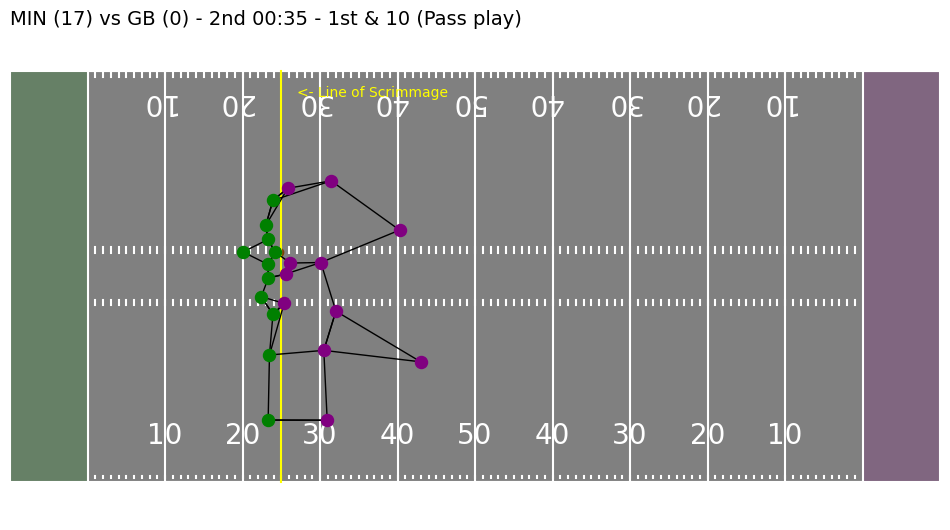

In [140]:
fig, ax = createFootballField(highlight_line=True, highlight_line_number=absoluteYardlineNumber - 10)

colors = {'MIN': 'purple',
            'GB': 'green',
            'football': '#7b3f00'}
    
plt.scatter(football['x'].values[0], football['y'].values[0], color=colors[football['club'].values[0]])

for key, value in all_dist.items():
        key_x = tracking_data[tracking_data['nflId'] == key]['x'].values[0]
        key_y = tracking_data[tracking_data['nflId'] == key]['y'].values[0]
        for player in value:
            player_x = tracking_data[tracking_data['nflId'] == player['nflId']]['x'].values[0]
            player_y = tracking_data[tracking_data['nflId'] == player['nflId']]['y'].values[0]
            plt.plot([key_x, player_x], [key_y, player_y], color='black', linewidth=1)
            
for index, player in tracking_data.iterrows():
    x = player['x']
    y = player['y']
    s = player['displayName']
    if s == 'football':
        continue
    plt.scatter(x, y, color=colors[player['club']], zorder=100, s=75)
    
homeAbbr = games.iloc[0]['homeTeamAbbr']
visitorAbbr = games.iloc[0]['visitorTeamAbbr']
homePoints = plays.iloc[0]['preSnapHomeScore']
visitorPoints = plays.iloc[0]['preSnapVisitorScore']
quarter = plays.iloc[0]['quarter']
down = plays.iloc[0]['down']
yardsToGo = plays.iloc[0]['yardsToGo']
gameClock = plays.iloc[0]['gameClock']
description = plays.iloc[0]['playDescription']

downSufix = 'st' if down == 1 else 'nd' if down == 2 else 'rd' if down == 3 else 'th'
quarterSufix = 'st' if quarter == 1 else 'nd' if quarter == 2 else 'rd' if quarter == 3 else 'th'

playType = 'Pass' if plays.iloc[0]['playResult'] == 1 else 'Run' if plays.iloc[0]['playResult'] == 0 else 'Other'

title = f"{homeAbbr} ({homePoints}) vs {visitorAbbr} ({visitorPoints}) - {quarter}{quarterSufix} {gameClock} - {down}{downSufix} & {yardsToGo} ({playType} play)"

wrapped_title = textwrap.fill(title, width=100)
    
plt.title(wrapped_title, fontsize=14, color='black', loc='left', multialignment='left')

In [139]:
plt.show()